##import labs

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn.functional as F
import networkx as nx


##Network

In [3]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.layers(x)


##inputs and parameter

In [4]:
input_size = 784  # For MNIST, images are 28x28
hidden_sizes = [128, 64]  # Example hidden layer sizes
output_size = 10  # MNIST has 10 classes

model = FullyConnectedNet(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.08)


In [5]:
"""


def create_network_graph(input_size, hidden_sizes, output_size):
    G = nx.DiGraph()
    # Add input layer nodes with subset attribute
    for i in range(input_size):
        G.add_node(f'Input_{i}', subset=0)

    # Add hidden layer nodes with subset attribute
    for i, size in enumerate(hidden_sizes, 1):
        for j in range(size):
            G.add_node(f'H{i}_{j}', subset=i)
            if i == 1:  # Connect first hidden layer to input layer
                for k in range(input_size):
                    G.add_edge(f'Input_{k}', f'H{i}_{j}')
            else:  # Connect to previous hidden layer
                for k in range(hidden_sizes[i-2]):
                    G.add_edge(f'H{i-1}_{k}', f'H{i}_{j}')

    # Add output layer nodes with subset attribute
    last_hidden_layer = len(hidden_sizes)
    for i in range(output_size):
        G.add_node(f'Output_{i}', subset=last_hidden_layer + 1)
        for j in range(hidden_sizes[-1]):
            G.add_edge(f'H{last_hidden_layer}_{j}', f'Output_{i}')

    return G


# Create graph
G = create_network_graph(input_size, hidden_sizes, output_size)

# Draw the graph
plt.figure(figsize=(10, 4))
pos = nx.multipartite_layout(G, subset_key='subset')  # Use 'subset' as subset_key
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold")
plt.title("Graph of the Fully Connected Neural Network")
plt.show()
"""

'\n\n\ndef create_network_graph(input_size, hidden_sizes, output_size):\n    G = nx.DiGraph()\n    # Add input layer nodes with subset attribute\n    for i in range(input_size):\n        G.add_node(f\'Input_{i}\', subset=0)\n\n    # Add hidden layer nodes with subset attribute\n    for i, size in enumerate(hidden_sizes, 1):\n        for j in range(size):\n            G.add_node(f\'H{i}_{j}\', subset=i)\n            if i == 1:  # Connect first hidden layer to input layer\n                for k in range(input_size):\n                    G.add_edge(f\'Input_{k}\', f\'H{i}_{j}\')\n            else:  # Connect to previous hidden layer\n                for k in range(hidden_sizes[i-2]):\n                    G.add_edge(f\'H{i-1}_{k}\', f\'H{i}_{j}\')\n\n    # Add output layer nodes with subset attribute\n    last_hidden_layer = len(hidden_sizes)\n    for i in range(output_size):\n        G.add_node(f\'Output_{i}\', subset=last_hidden_layer + 1)\n        for j in range(hidden_sizes[-1]):\n    

##loading dataset

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# Assuming the same transform has been defined as before
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 111308156.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 64986960.21it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31380098.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12854607.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



##load random images to displaay

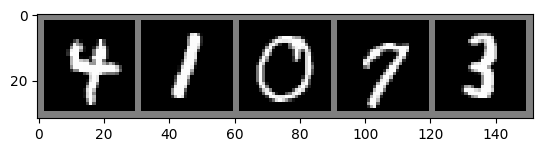

Labels:     4     1     0     7     3


In [7]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select 5 random images
indices = np.random.choice(range(len(images)), 5, replace=False)
selected_images = images[indices]
selected_labels = labels[indices]

# Show images
imshow(torchvision.utils.make_grid(selected_images))
# Print labels
print('Labels:', ' '.join('%5s' % selected_labels[j].item() for j in range(5)))

##Traing and validation with network

In [8]:
import matplotlib.pyplot as plt
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement before stopping
patience_counter = 0  # Tracks how many epochs have gone by without improvement

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

epochs = 50
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)

    # Validation
    model.eval()
    validation_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    validation_losses.append(validation_loss / len(test_loader))
    validation_accuracies.append(100. * correct / total)

    # Check for improvement
    if validation_losses[-1] < best_val_loss:
        best_val_loss = validation_losses[-1]
        patience_counter = 0  # Reset counter
        # Save the model if you want to keep the best one
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    # Early stopping check
    if patience_counter >= patience:
        print(f"Stopping early at epoch {epoch+1}")
        break

    print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {validation_losses[-1]:.4f}, Val Accuracy: {validation_accuracies[-1]:.2f}%')

Epoch: 1, Train Loss: 0.4768, Train Accuracy: 84.78%, Val Loss: 0.2826, Val Accuracy: 91.08%
Epoch: 2, Train Loss: 0.1901, Train Accuracy: 94.21%, Val Loss: 0.1432, Val Accuracy: 95.92%
Epoch: 3, Train Loss: 0.1371, Train Accuracy: 95.78%, Val Loss: 0.1197, Val Accuracy: 96.23%
Epoch: 4, Train Loss: 0.1084, Train Accuracy: 96.67%, Val Loss: 0.0974, Val Accuracy: 96.82%
Epoch: 5, Train Loss: 0.0898, Train Accuracy: 97.16%, Val Loss: 0.1067, Val Accuracy: 96.65%
Epoch: 6, Train Loss: 0.0773, Train Accuracy: 97.61%, Val Loss: 0.1140, Val Accuracy: 96.37%
Epoch: 7, Train Loss: 0.0676, Train Accuracy: 97.86%, Val Loss: 0.1117, Val Accuracy: 96.53%
Epoch: 8, Train Loss: 0.0603, Train Accuracy: 98.05%, Val Loss: 0.0931, Val Accuracy: 97.13%
Epoch: 9, Train Loss: 0.0554, Train Accuracy: 98.20%, Val Loss: 0.0869, Val Accuracy: 97.36%
Epoch: 10, Train Loss: 0.0480, Train Accuracy: 98.40%, Val Loss: 0.0892, Val Accuracy: 97.40%
Epoch: 11, Train Loss: 0.0435, Train Accuracy: 98.61%, Val Loss: 0.08

##Accuracy and loss graphs

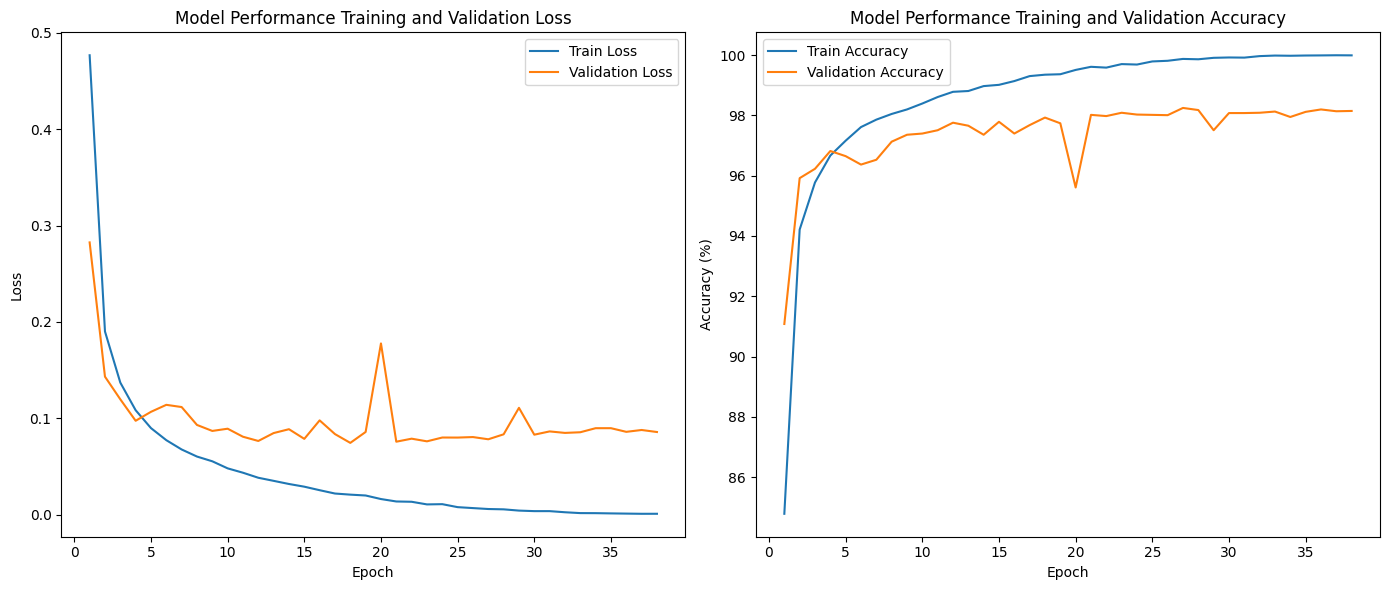

In [9]:
def plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies, title_prefix=""):
    # Dynamically adjust the epoch range to the length of the collected metrics
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.title(f'{title_prefix} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
    plt.title(f'{title_prefix} Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function with your collected metrics
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies, "Model Performance")


##Testing  evaluation

In [10]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

with torch.no_grad():  # No gradients needed
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0858, Test Accuracy: 98.15%


##Part (C)


In [11]:
# Utility for one-hot encoding
def to_one_hot(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

##without softmax

In [23]:
import time

def train_and_evaluate_with_early_stopping_and_timing(model, criterion, optimizer, train_loader, test_loader, epochs=30, use_softmax=False, patience=10):
    start_time = time.time()  # Record the start time

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            labels_one_hot = to_one_hot(labels).to(inputs.device)

            optimizer.zero_grad()
            outputs = model(inputs)
            if use_softmax:
                outputs = nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels_one_hot)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                labels_one_hot = to_one_hot(labels).to(inputs.device)
                outputs = model(inputs)
                if use_softmax:
                    outputs = nn.functional.softmax(outputs, dim=1)
                loss = criterion(outputs, labels_one_hot)
                test_loss += loss.item()
                _, predicted_test = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model)
                break

    end_time = time.time()  # Record the end time
    training_time = end_time - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    return train_losses, train_accuracies, test_losses, test_accuracies, training_time


##traning

In [24]:
model_mse = FullyConnectedNet(28*28, [128, 64], 10) #or model
criterion_mse = nn.MSELoss()
optimizer_mse = optim.SGD(model_mse.parameters(),lr=0.08)
# Train with timing and early stopping
results = train_and_evaluate_with_early_stopping_and_timing(
    model_mse, criterion_mse, optimizer_mse, train_loader, test_loader, epochs=30, use_softmax=False, patience=10)

# Unpack the results
train_losses_without_softmax, train_accuracies_without_softmax, test_losses_without_softmax, test_accuracies_without_softmax, training_time_without_softmax = results


Epoch 1: Train Loss: 0.0450, Train Accuracy: 79.85%, Test Loss: 0.0308, Test Accuracy: 88.49%
Epoch 2: Train Loss: 0.0265, Train Accuracy: 89.60%, Test Loss: 0.0224, Test Accuracy: 91.56%
Epoch 3: Train Loss: 0.0208, Train Accuracy: 91.52%, Test Loss: 0.0191, Test Accuracy: 92.49%
Epoch 4: Train Loss: 0.0179, Train Accuracy: 92.63%, Test Loss: 0.0164, Test Accuracy: 93.48%
Epoch 5: Train Loss: 0.0161, Train Accuracy: 93.36%, Test Loss: 0.0149, Test Accuracy: 94.19%
Epoch 6: Train Loss: 0.0148, Train Accuracy: 93.96%, Test Loss: 0.0148, Test Accuracy: 94.00%
Epoch 7: Train Loss: 0.0137, Train Accuracy: 94.41%, Test Loss: 0.0135, Test Accuracy: 94.56%
Epoch 8: Train Loss: 0.0129, Train Accuracy: 94.74%, Test Loss: 0.0128, Test Accuracy: 94.74%
Epoch 9: Train Loss: 0.0122, Train Accuracy: 95.08%, Test Loss: 0.0120, Test Accuracy: 95.19%
Epoch 10: Train Loss: 0.0116, Train Accuracy: 95.39%, Test Loss: 0.0117, Test Accuracy: 95.33%
Epoch 11: Train Loss: 0.0111, Train Accuracy: 95.61%, Test 

##ploting

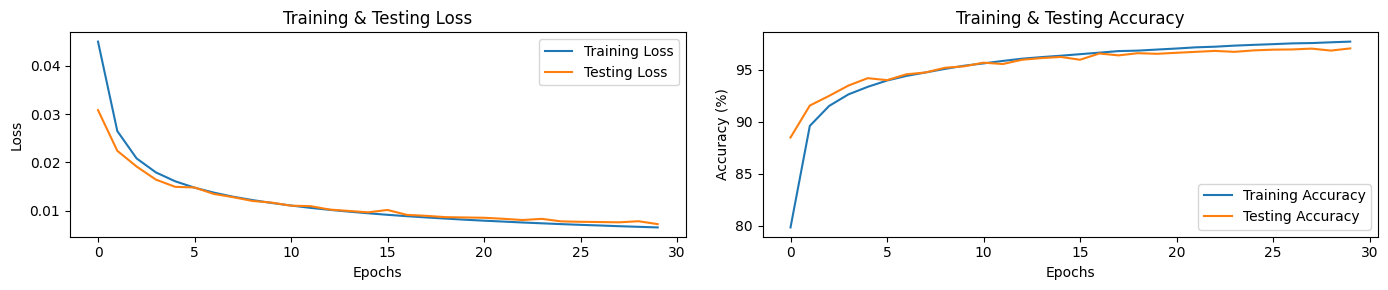

In [25]:
import matplotlib.pyplot as plt

def plot_training_testing_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    """
    Plots the training and testing loss and accuracy.

    Parameters:
    - train_losses: List of training losses.
    - train_accuracies: List of training accuracies.
    - test_losses: List of testing (validation) losses.
    - test_accuracies: List of testing (validation) accuracies.
    """
    plt.figure(figsize=(14, 3))

    # Plotting training and testing loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.title('Training & Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and testing accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.title('Training & Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_testing_metrics(train_losses_without_softmax, train_accuracies_without_softmax, test_losses_without_softmax, test_accuracies_without_softmax)


In [26]:
# Verify the content of the lists before plotting
print("Training Losses:", train_losses_without_softmax)
print("Training Accuracies:", train_accuracies_without_softmax)
print("Testing Losses:", test_losses_without_softmax)
print("Testing Accuracies:", test_accuracies_without_softmax)

# If the lists look correct, try calling the plotting function again


Training Losses: [0.04500250251435522, 0.026482796713487425, 0.020819051105822963, 0.01792341752299495, 0.0160850708840538, 0.014763589111416897, 0.013738341141007603, 0.01288890568658646, 0.01219847069374089, 0.011597707964428293, 0.011067688833477337, 0.010588999066664688, 0.010174096899051497, 0.009804685703858035, 0.009461819844842671, 0.009145974985826245, 0.008860899238481816, 0.008602172509133657, 0.008366291826493594, 0.008134001018558898, 0.00792859002465267, 0.007745016036855021, 0.007552138530959024, 0.007386486793655767, 0.007217501672650022, 0.0070667086265433126, 0.006932385743154821, 0.00678758035579732, 0.006660700801249617, 0.006532317623922994]
Training Accuracies: [79.85, 89.60333333333334, 91.52166666666666, 92.63166666666666, 93.35666666666667, 93.96333333333334, 94.40666666666667, 94.74, 95.08, 95.38833333333334, 95.61, 95.84666666666666, 96.06166666666667, 96.21333333333334, 96.34666666666666, 96.495, 96.64, 96.79166666666667, 96.83833333333334, 96.94, 97.04, 97.

##wiht softmax

In [20]:
import time

def train_and_evaluate_with_early_stopping_and_timing(model, criterion, optimizer, train_loader, test_loader, epochs=30, use_softmax=True, patience=10):
    start_time = time.time()  # Record the start time

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            labels_one_hot = to_one_hot(labels).to(inputs.device)

            optimizer.zero_grad()
            outputs = model(inputs)
            if use_softmax:
                outputs = nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels_one_hot)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                labels_one_hot = to_one_hot(labels).to(inputs.device)
                outputs = model(inputs)
                if use_softmax:
                    outputs = nn.functional.softmax(outputs, dim=1)
                loss = criterion(outputs, labels_one_hot)
                test_loss += loss.item()
                _, predicted_test = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model)
                break

    end_time = time.time()  # Record the end time
    training_time = end_time - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    return train_losses, train_accuracies, test_losses, test_accuracies, training_time


Epoch 1: Train Loss: 0.0852, Train Accuracy: 35.28%, Test Loss: 0.0739, Test Accuracy: 47.00%
Epoch 2: Train Loss: 0.0520, Train Accuracy: 66.00%, Test Loss: 0.0319, Test Accuracy: 83.71%
Epoch 3: Train Loss: 0.0249, Train Accuracy: 85.84%, Test Loss: 0.0193, Test Accuracy: 88.36%
Epoch 4: Train Loss: 0.0185, Train Accuracy: 88.53%, Test Loss: 0.0162, Test Accuracy: 89.73%
Epoch 5: Train Loss: 0.0163, Train Accuracy: 89.68%, Test Loss: 0.0147, Test Accuracy: 90.35%
Epoch 6: Train Loss: 0.0150, Train Accuracy: 90.34%, Test Loss: 0.0138, Test Accuracy: 91.09%
Epoch 7: Train Loss: 0.0142, Train Accuracy: 90.88%, Test Loss: 0.0133, Test Accuracy: 91.19%
Epoch 8: Train Loss: 0.0135, Train Accuracy: 91.21%, Test Loss: 0.0129, Test Accuracy: 91.58%
Epoch 9: Train Loss: 0.0131, Train Accuracy: 91.55%, Test Loss: 0.0128, Test Accuracy: 91.67%
Epoch 10: Train Loss: 0.0126, Train Accuracy: 91.78%, Test Loss: 0.0121, Test Accuracy: 91.96%
Epoch 11: Train Loss: 0.0122, Train Accuracy: 92.08%, Test 

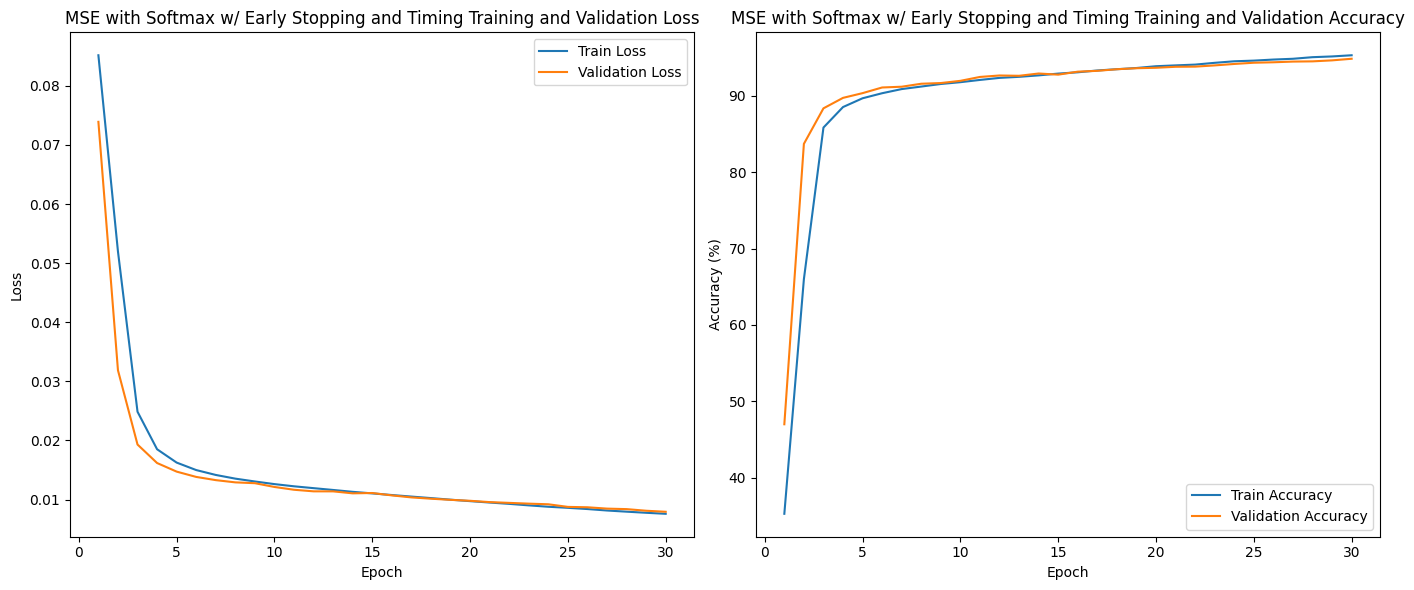

In [21]:
# Assuming the model and other components are already defined as before
model_softmax = FullyConnectedNet(28*28, [128, 64], 10)
criterion_mse_softmax = nn.MSELoss()
optimizer_mse_softmax = optim.SGD(model_softmax.parameters(),lr=0.08)

# Train the model with softmax before MSE loss, timing, and early stopping
results_softmax = train_and_evaluate_with_early_stopping_and_timing(
    model_softmax, criterion_mse_softmax, optimizer_mse_softmax, train_loader, test_loader, epochs=30, use_softmax=True, patience=10)

# Unpack the results
train_losses_softmax, train_accuracies_softmax, test_losses_softmax, test_accuracies_softmax, training_time_softmax = results_softmax

# Plot the metrics for the softmax case
plot_metrics(train_losses_softmax, train_accuracies_softmax, test_losses_softmax, test_accuracies_softmax, "MSE with Softmax w/ Early Stopping and Timing")